In [13]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [14]:
#### Preprocecing ###

In [15]:
jh_dir = "../../COVID-19"

In [16]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [17]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [18]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [19]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [20]:
### Data Preparation ###

In [52]:
country = 'Korea, South'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-26')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 6000_0000
iteration=2000
repeat = 1000

In [53]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [23]:
### Model ###

In [24]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f472b1d2ccdff3099b75bd7cdafce0c4 NOW.


In [25]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a5549457d9a2746de59f880209cc026 NOW.


In [55]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f472b1d2ccdff3099b75bd7cdafce0c4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   113.67    0.15   9.28  96.33 107.23 113.49 119.84 132.47   3711    1.0
b            0.46    0.01   0.55   0.03   0.12   0.27   0.58   1.92   2935    1.0
p             0.3  5.7e-3   0.24   0.03   0.11   0.22   0.42   0.89   1720    1.0
q             1.0  5.1e-6 3.6e-4    1.0    1.0    1.0    1.0    1.0   5073    1.0
NI[1]       15.65    0.04   2.62  10.62  13.81  15.68  17.42  20.83   4407    1.0
NI[2]       15.51    0.05   2.75  10.09  13.73   15.5  17.31  20.99   3450    1.0
NI[3]       17.19    0.05   2.85  11.71  15.22  17.15  19.08  22.93   3716    1.0
NI[4]        19.4    0.05   2.95  13.82  17.35  19.36  21.41  25.27   3418    1.0
NI[5]       21.29    0.05   3.07 

In [56]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits, control={'adapt_delta':0.99999})
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7a5549457d9a2746de59f880209cc026.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   8.35    0.03    2.1   4.88   6.85   8.15    9.6  13.06   4139    1.0
b_beta      1.0  3.5e-4   0.03   0.94   0.98    1.0   1.02   1.07   7775    1.0
b[1]       4.59    0.04   2.12   1.32   3.04   4.26   5.75   9.71   2276    1.0
b[2]       6.95    0.09   3.28   1.76   4.59   6.49   8.79  14.57   1201    1.0
b[3]       9.97    0.15   4.25   3.12   6.91   9.45   12.5  19.59    839    1.0
b[4]      12.86    0.21   5.06   4.77    9.1  12.35  15.98  24.28    559    1.0
b[5]      14.76    0.29   5.79   5.56   10.6  14.09  18.21  27.98    404   1.01
b[6]       15.3    0.36    6.4   5.27  10.81  14.42  18.82  30.21    312   1.01
b[7]      16.13    0.42   7.05   5.16  11.03  15.17

In [57]:
print(fit_every)

Inference for Stan model: anon_model_7a5549457d9a2746de59f880209cc026.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      8.35    0.03    2.1   4.88   6.85   8.15    9.6  13.06   4139    1.0
b_beta         1.0  3.5e-4   0.03   0.94   0.98    1.0   1.02   1.07   7775    1.0
b[1]          4.59    0.04   2.12   1.32   3.04   4.26   5.75   9.71   2276    1.0
b[2]          6.95    0.09   3.28   1.76   4.59   6.49   8.79  14.57   1201    1.0
b[3]          9.97    0.15   4.25   3.12   6.91   9.45   12.5  19.59    839    1.0
b[4]         12.86    0.21   5.06   4.77    9.1  12.35  15.98  24.28    559    1.0
b[5]         14.76    0.29   5.79   5.56   10.6  14.09  18.21  27.98    404   1.01
b[6]          15.3    0.36    6.4   5.27  10.81  14.42  18.82  30.21    312   1.01
b[7]         16.13    0.42   7.05   5.16  11.03  15.17  20.14   

In [17]:
# Save models

In [18]:
## Saving results

In [58]:
import pickle
with open("sm_const_fit-Korea.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
import pickle
with open("sm_every_fit-Korea.pkl", "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
### Load modesl

In [13]:
with open("sm_const_fit-Korea.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [14]:
with open("sm_every_fit-Korea.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [24]:
### model selection

In [60]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')

In [61]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo  6328.39  1175.48
p_loo   1116.57        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        4    4.8%
 (0.5, 0.7]   (ok)          6    7.1%
   (0.7, 1]   (bad)        21   25.0%
   (1, Inf)   (very bad)   53   63.1%

In [62]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo   625.62    25.83
p_loo     62.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10   11.9%
 (0.5, 0.7]   (ok)         12   14.3%
   (0.7, 1]   (bad)        47   56.0%
   (1, Inf)   (very bad)   15   17.9%

In [63]:
az.compare({'const':data_const, 'everyday':data_every})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,583.359,41.5786,0,1,1427.85,0,True,deviance
const,1,7270.2,1587.47,6686.84,0,22.8682,1456.24,True,deviance


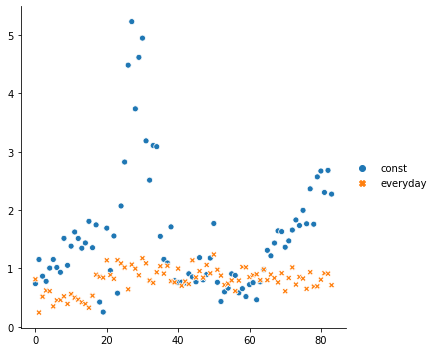

In [64]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k})
sns.relplot(data=df)

In [65]:
df.idxmax()

const       27
everyday    50
dtype: int64

In [31]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [ ]:
### Visualization ###

In [66]:
def extract(upto):
    index=pd.date_range(start=epoch, end=upto)
    b = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
    q = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
    NI = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
    a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
    d = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    p = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    C = NI.cumsum()
    NI0 = q*NI
    C0 = NI0.cumsum()
    return a, d, p, b, q, NI, NI0, C, C0

In [67]:
a_e, d_e, p_e, b_e, q_e, NI_e, NI0_e, C_e, C0_e = extract(upto=pd.to_datetime('2020-04-24'))

In [68]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

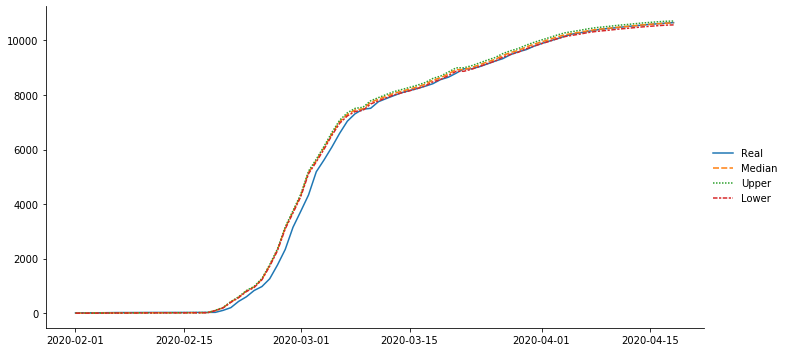

In [69]:
draw(C0_e, real=confirmed[country])

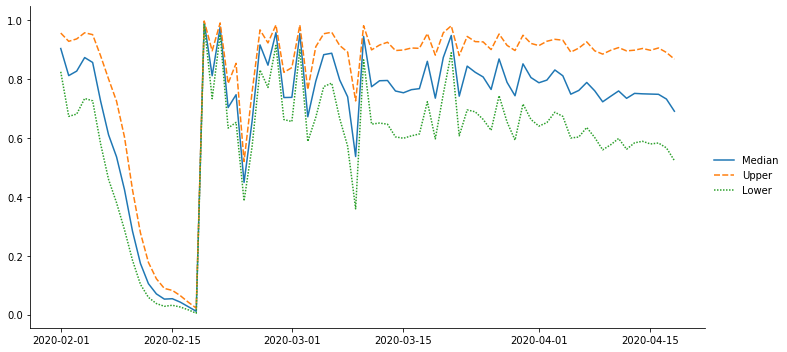

In [70]:
draw(q_e)

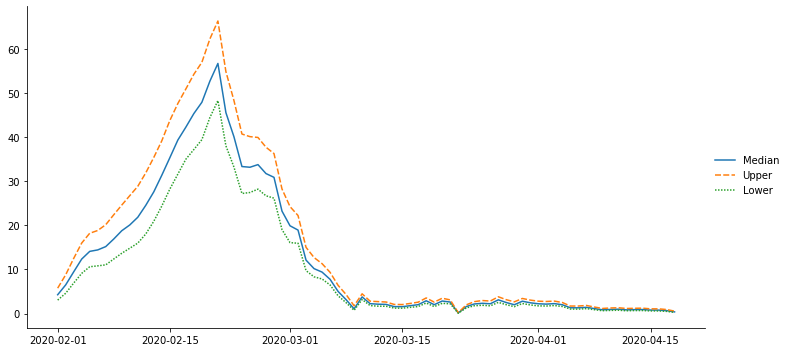

In [71]:
draw(b_e)

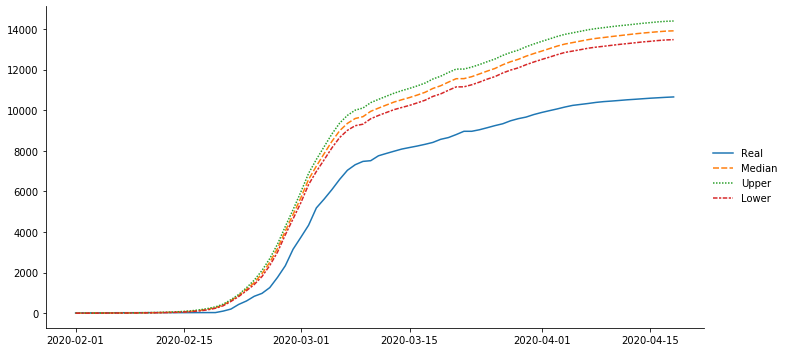

In [72]:
draw(C_e, real=confirmed[country])

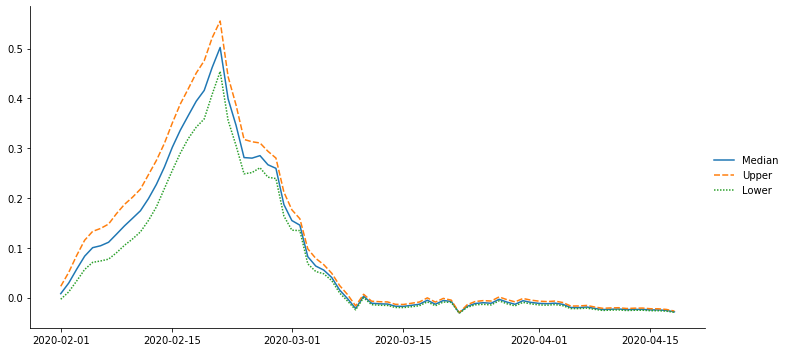

In [78]:
a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
p = pd.DataFrame(data_every.posterior['p'].stack(sample=('chain', 'draw')).values)
beta = pd.DataFrame(np.array([b_e[i].values * -np.log(1 - p.iloc[i].values) - a.iloc[i].values for i in range(len(p))]).T, index=b_e.index)
draw(beta)

In [76]:
data_every.posterior

<xarray.Dataset>
Dimensions:   (NI_dim_0: 84, b_dim_0: 84, chain: 4, draw: 1000, q_dim_0: 84)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * b_dim_0   (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83
  * q_dim_0   (q_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83
  * NI_dim_0  (NI_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 75 76 77 78 79 80 81 82 83
Data variables:
    init_inf  (chain, draw) float64 11.53 8.086 9.395 ... 8.085 9.213 8.792
    b_beta    (chain, draw) float64 0.99 1.027 0.9942 ... 0.9994 1.006 0.9699
    b         (chain, draw, b_dim_0) float64 7.556 7.926 17.69 ... 0.1809 0.1361
    q         (chain, draw, q_dim_0) float64 0.6504 0.5778 ... 0.9936 0.8912
    q_factor  (chain, draw) float64 23.45 19.2 23.13 26.47 ... 29.31 18.28 30.18
    NI        (chain, draw, NI_dim_0) float64 2.085 1.247 1.949 ... 8.0 11.32
    a         (chain, draw) float64 0.03242 0.03176 0.03247 ... 0.03281 0.03141
    d         (chain, draw) float64 0.0008549 0.0009441 ... 0.000872 0.0008971
    p         (chain, draw) float64 0.009246 0.00949 0.008814 ... 0.01 0.009356
Attributes:
    created_at:                 2020-04-27T22:05:54.178082
    inference_library:          pystan
    inference_library_version:  2.19.0.0